In [25]:
from Utils.Solver import *
from Utils.Signals import *

In [26]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores
start_date ='2021-01-15'
end_date ='2022-01-15'

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


## Signals 

In [27]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


### RSI SIGNAL

In [28]:
# Calculate the RSI signal scores
rsi_signal_scores = calculate_rsi_signal(data, tickers, date='2022-12-23', period=14)
rsi_scores = [score[1] for score in rsi_signal_scores]
rsi_scores_array = np.array(rsi_scores)
print(rsi_scores_array)

[35.69461149 44.14050943 19.81992342 38.02756082 40.44854622]


     pcost       dcost       gap    pres   dres
 0: -1.2478e-01 -1.1479e+00  1e+00  1e-16  3e+00
 1: -1.2557e-01 -1.5230e-01  3e-02  1e-16  7e-02
 2: -1.2688e-01 -1.2801e-01  1e-03  2e-16  1e-03
 3: -1.2692e-01 -1.2694e-01  2e-05  2e-16  1e-05
 4: -1.2692e-01 -1.2692e-01  2e-07  1e-16  1e-07
 5: -1.2692e-01 -1.2692e-01  2e-09  8e-17  1e-09
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.20047984634318047), 'MSFT': np.float64(0.2597472585827308), 'TSLA': np.float64(0.08908240049666549), 'AMZN': np.float64(0.216850855050517), 'GOOG': np.float64(0.23383963952690626)}
Final Portfolio Weights: [0.20047985 0.25974726 0.0890824  0.21685086 0.23383964]


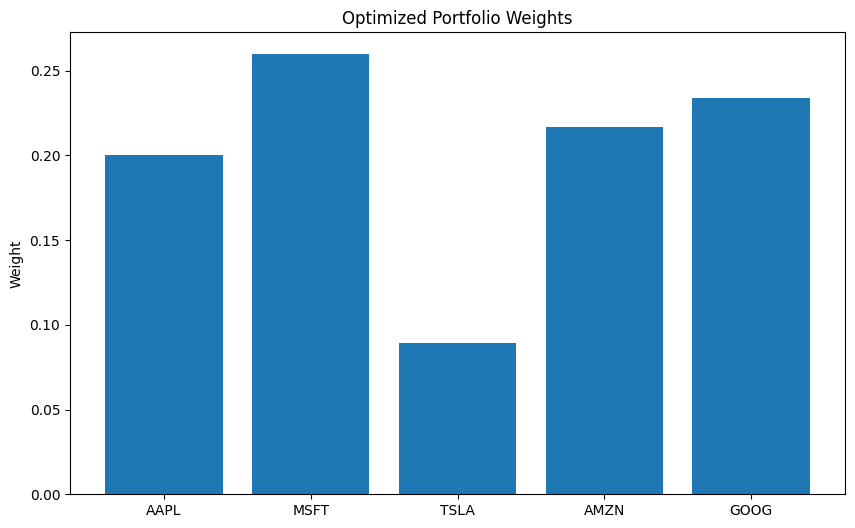

In [29]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
rsi_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, rsi_scores_array)
print("Final Portfolio Weights:", rsi_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

Total Portfolio Return: 147.66%
Annualized Portfolio Return: 147.66%


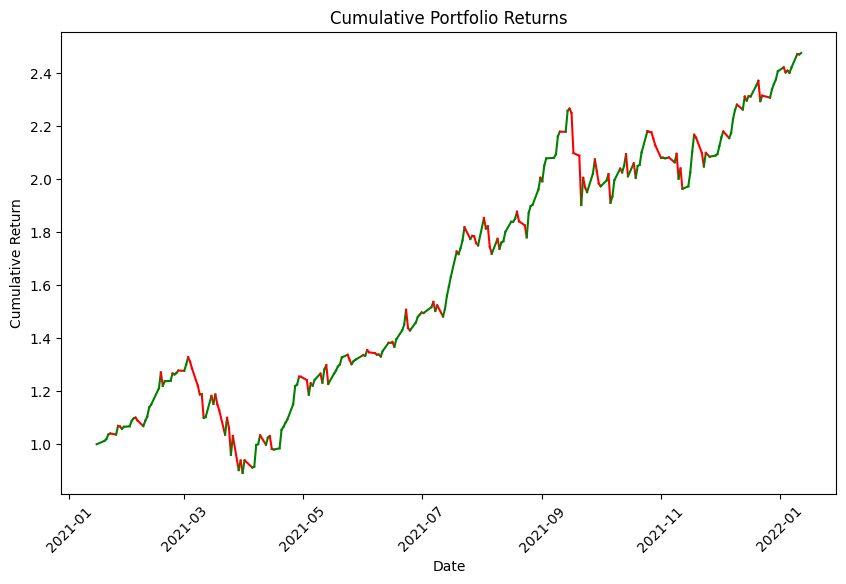

In [30]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, rsi_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### MACD signal

In [31]:
# Calculate MACD for a specific date (e.g., '2021-01-15')
macd_signal = calculate_macd_signal(data, tickers, '2021-01-15')
macd_scores = [score[1] for score in macd_signal]
macd_scores_array = np.array(macd_scores)

     pcost       dcost       gap    pres   dres
 0: -5.1576e+00 -3.2420e+00  2e+01  5e+00  1e+00
 1: -9.9484e-01 -1.9725e+00  1e+00  9e-03  2e-03
 2: -1.0944e+00 -1.1813e+00  9e-02  7e-04  2e-04
 3: -1.1233e+00 -1.1306e+00  7e-03  2e-05  4e-06
 4: -1.1260e+00 -1.1268e+00  8e-04  2e-16  3e-16
 5: -1.1262e+00 -1.1262e+00  7e-05  1e-16  3e-16
 6: -1.1262e+00 -1.1262e+00  9e-07  6e-17  3e-16
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.3348170646844276), 'MSFT': np.float64(0.6384756024573318), 'TSLA': np.float64(3.039861351089629e-09), 'AMZN': np.float64(0.02670731452136598), 'GOOG': np.float64(1.5297013252352028e-08)}
Final Portfolio Weights: [3.34817065e-01 6.38475602e-01 3.03986135e-09 2.67073145e-02
 1.52970133e-08]


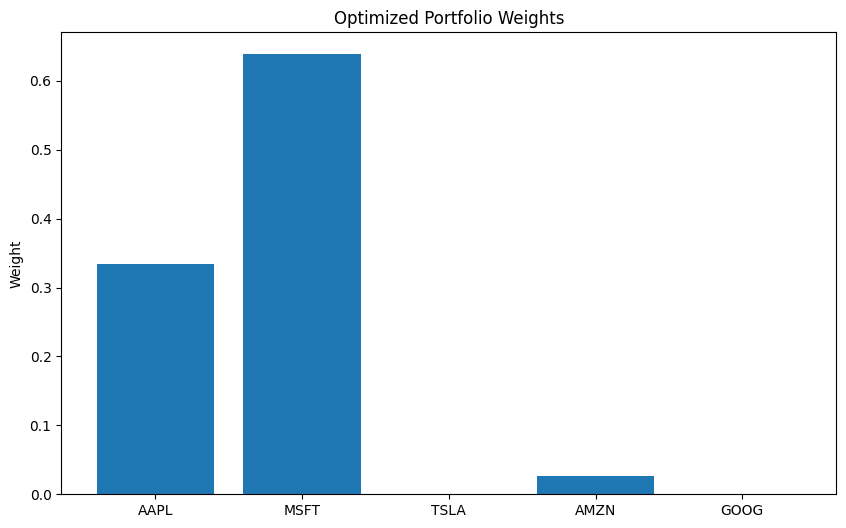

In [32]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
macd_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, macd_scores_array)
print("Final Portfolio Weights:", macd_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=macd_portfolio_weights)

Total Portfolio Return: 76.57%
Annualized Portfolio Return: 76.57%


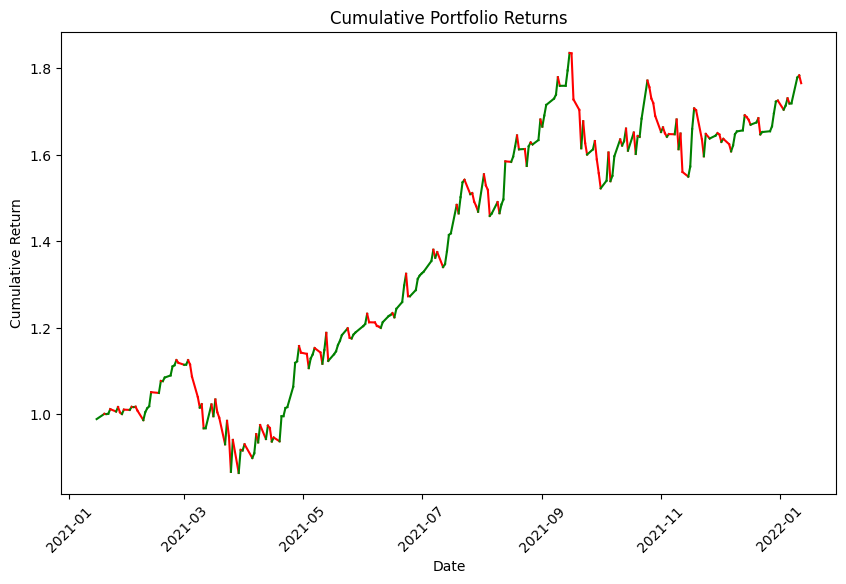

In [33]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, macd_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### SMA signal

In [34]:
# Calculate SMA crossover signal for a specific date (e.g., '2021-01-15')
sma_signal = calculate_sma_signal(data, tickers, '2021-01-15')
sma_scores = [score[1] for score in sma_signal]
sma_scores_array = np.array(sma_scores)
print(sma_scores_array)

[19.9933144  13.46059334 81.52420954 11.69167049 11.39483053]


     pcost       dcost       gap    pres   dres
 0: -2.0345e-01 -1.3608e+00  1e+00  0e+00  3e+00
 1: -2.2219e-01 -3.2681e-01  1e-01  1e-16  3e-01
 2: -2.3998e-01 -2.5115e-01  1e-02  5e-17  7e-17
 3: -2.4069e-01 -2.4133e-01  6e-04  1e-16  3e-17
 4: -2.4070e-01 -2.4071e-01  8e-06  4e-17  4e-17
 5: -2.4070e-01 -2.4070e-01  8e-08  2e-16  8e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.13101378027739646), 'MSFT': np.float64(0.07186848481081752), 'TSLA': np.float64(0.6880979772041943), 'AMZN': np.float64(0.05585354770856608), 'GOOG': np.float64(0.05316620999902573)}
Final Portfolio Weights: [0.13101378 0.07186848 0.68809798 0.05585355 0.05316621]


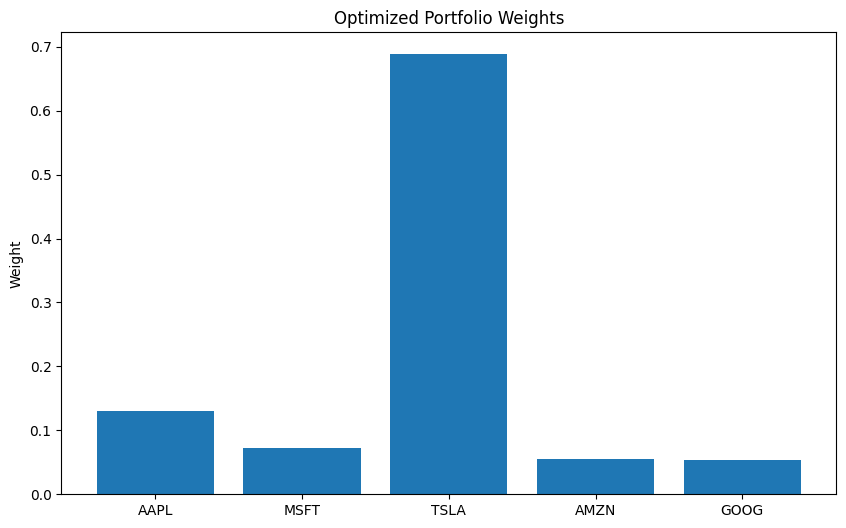

In [35]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
sma_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, sma_scores_array)
print("Final Portfolio Weights:", sma_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=sma_portfolio_weights)

Total Portfolio Return: 54.65%
Annualized Portfolio Return: 54.65%


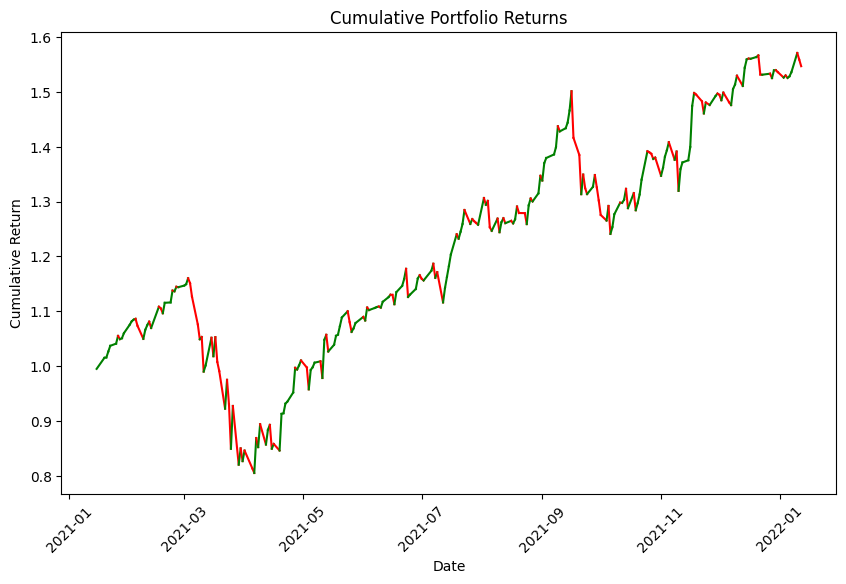

In [36]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

rsi_signal_scores [48.09325469 42.6741412  66.28230185 42.67309414 46.45338899]
macd_signal_scores [-0.81745135 -0.98491359  1.88721933 -0.64751188 -0.12669506]
sma_signal_scores [19.9933144  13.46059334 81.52420954 11.69167049 11.39483053]
[ 67.26911775  55.14982096 149.69373072  53.71725276  57.72152446]
     pcost       dcost       gap    pres   dres
 0: -1.3988e-01 -1.2314e+00  1e+00  0e+00  3e+00
 1: -1.4431e-01 -2.1518e-01  7e-02  1e-16  2e-01
 2: -1.4874e-01 -1.5166e-01  3e-03  3e-17  4e-17
 3: -1.4876e-01 -1.4879e-01  3e-05  2e-16  3e-17
 4: -1.4876e-01 -1.4876e-01  3e-07  1e-16  2e-17
 5: -1.4876e-01 -1.4876e-01  3e-09  9e-17  5e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.16923107453180944), 'MSFT': np.float64(0.12973410841860564), 'TSLA': np.float64(0.43785414142692286), 'AMZN': np.float64(0.1250653485694147), 'GOOG': np.float64(0.13811532705324747)}


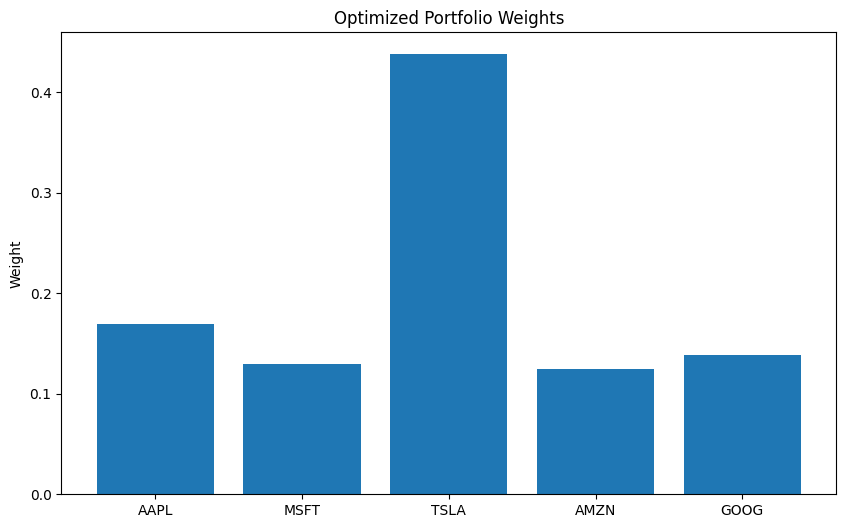

Total Portfolio Return: 92.24%
Annualized Portfolio Return: 92.24%


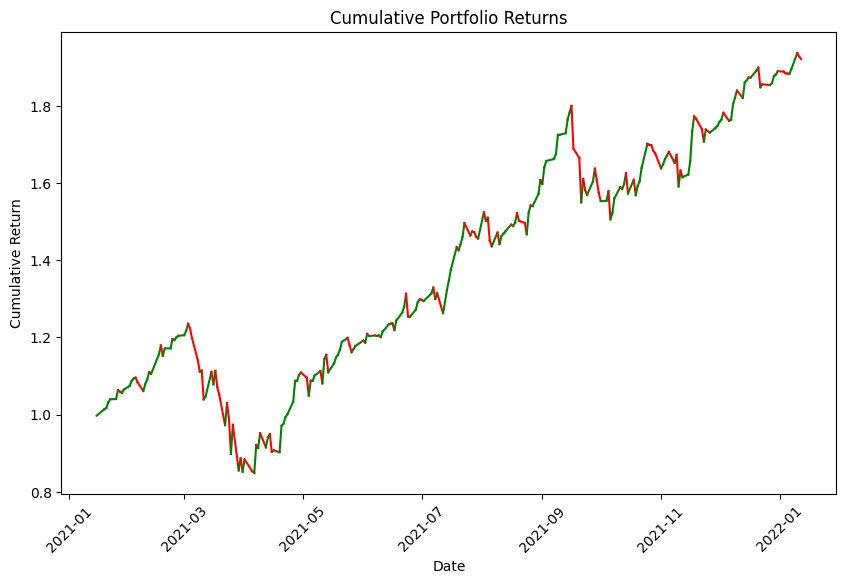

In [37]:

trading_dates = ['2021-01-15']
# Example of Iterative Optimization
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    


# Prepare data

RENDU ICI:
JE VEUX PREPARER MON DATA POUR LAVOIR COMME DANS MON CAHIER

In [44]:
%pip install sklearn

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import yfinance as yf
import talib as ta

# Sample data preparation: Example with RSI, MACD, SMA scores and returns
# Assuming you already have the signal scores (RSI, MACD, SMA) and returns for each stock and date
# Example data for demonstration:
data = pd.DataFrame({
    'RSI_score': [0.2, 0.5, 0.6, 0.3, 0.7],
    'MACD_score': [0.5, 0.7, 0.3, 0.8, 0.6],
    'SMA_score': [1.7, 1.4, 1.6, 1.8, 1.3],
    'returns': [143, 152, 167, 158, 170]
})

# Features: RSI, MACD, SMA scores
X = data[['RSI_score', 'MACD_score', 'SMA_score']].values

# Target: Returns
y = data['returns'].values

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the weights (coefficients) assigned to each signal
weights = model.coef_

# Display the results
print("Optimal Weights for Each Signal:")
print(f"RSI Weight: {weights[0]:.4f}")
print(f"MACD Weight: {weights[1]:.4f}")
print(f"SMA Weight: {weights[2]:.4f}")

# Predict the portfolio return based on new signal scores
new_signal_scores = np.array([[0.3, 0.6, 1.5]])  # Example new signal scores
predicted_return = model.predict(new_signal_scores)
print(f"Predicted Portfolio Return: {predicted_return[0]:.2f}")

Optimal Weights for Each Signal:
RSI Weight: 83.1169
MACD Weight: 10.7792
SMA Weight: 43.6364
Predicted Portfolio Return: 142.30


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SignalWeightModel(tf.keras.Model):
    def __init__(self):
        super(SignalWeightModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(3, activation='softmax')  # Three outputs: RSI, MACD, SMA weights

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
signal_weight_model = SignalWeightModel()
signal_weight_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [ ]:
class PortfolioOptimizerRL:
    def __init__(self, model):
        self.model = model
        self.discount_factor = 0.99  # Discount factor for future rewards

    def train(self, tickers, data, signals, portfolio_solver, num_epochs=100):
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            for date in data.index:
                # Step 1: Prepare the current state (signal scores for each stock)
                rsi_signal_scores = calculate_rsi_signal(data, tickers, date)
                rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])

                macd_signal_scores = calculate_macd_signal(data, tickers, date)
                macd_scores_array = np.array([score[1] for score in macd_signal_scores])

                sma_signal_scores = calculate_sma_signal(data, tickers, date)
                sma_scores_array = np.array([score[1] for score in sma_signal_scores])

                state = np.array([rsi_scores_array, macd_scores_array, sma_scores_array]).flatten()

                # Step 2: Predict the weights for each signal using the model
                predicted_weights = self.model(state.reshape(1, -1))

                # Step 3: Combine signals with the predicted weights
                combined_scores = combine_signals(predicted_weights[0].numpy(), [rsi_scores_array, macd_scores_array, sma_scores_array])
            
                # Check for NaN values in combined_scores
                if np.any(np.isnan(combined_scores)) or np.any(np.isinf(combined_scores)):
                    continue  # Skip this iteration if there are invalid values

                print(f"Optimized Portfolio Weights:\n{dict(zip(tickers, combined_scores))}")

                # Step 4: Use the portfolio solver to get the portfolio weights based on the combined scores
                portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

                # Step 5: Calculate the portfolio return (reward)
                cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
                reward = annualized_return  # or another performance metric

                # Step 6: Update the model based on the reward
                with tf.GradientTape() as tape:
                    # Forward pass
                    predicted_weights = self.model(state.reshape(1, -1))

                    # Calculate the loss (negative of the reward to minimize loss)
                    loss = -reward

                # Backpropagation
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                print(f"Date: {date}, Reward: {reward}, Loss: {loss}")

In [ ]:
# Initialize the portfolio solver
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Initialize the reinforcement learning optimizer
rl_optimizer = PortfolioOptimizerRL(signal_weight_model)

# Train the model
rl_optimizer.train(tickers, data, signals=None, portfolio_solver=portfolio_solver, num_epochs=100)


Epoch 1/100
Optimized Portfolio Weights:
{'AAPL': np.float64(0.9399637985392695), 'MSFT': np.float64(1.678885730199132), 'TSLA': np.float64(0.5599968165893919), 'AMZN': np.float64(1.5804423783625388), 'GOOG': np.float64(0.8213807742652465)}
     pcost       dcost       gap    pres   dres
 0: -1.3331e-01 -1.1798e+00  1e+00  1e-16  3e+00
 1: -1.3575e-01 -1.7834e-01  4e-02  2e-16  1e-01
 2: -1.3917e-01 -1.4142e-01  2e-03  2e-16  8e-04
 3: -1.3925e-01 -1.3931e-01  6e-05  1e-16  1e-05
 4: -1.3925e-01 -1.3926e-01  6e-07  8e-17  1e-07
 5: -1.3925e-01 -1.3925e-01  6e-09  6e-17  1e-09
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.16054009140923137), 'MSFT': np.float64(0.32604933798078234), 'TSLA': np.float64(0.075432325766295), 'AMZN': np.float64(0.30399926123727194), 'GOOG': np.float64(0.13397898360641947)}
Total Portfolio Return: 105.31%
Annualized Portfolio Return: 105.31%


AttributeError: 'numpy.float64' object has no attribute '_id'